In [1]:
## V3 CREATED 
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.1.0
Default GPU Device: /device:GPU:0


In [2]:
import pandas as pd

full_data = pd.read_csv('result.csv', header=None)
trader_ranks = full_data[full_data.columns[0]]
data = full_data.drop(full_data.columns[0], axis=1)


D:\Users\Matt\anaconda3\envs\gputest\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data[9][0] = 3.9750000000000227
data[9] = data[9].astype(float)
print(data.head(10))
print(trader_ranks.head(10))
type(data[9][5])

D:\Users\Matt\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


        1   2           3           4           5           6           7   \
0   3.9750   0  146.000000 -149.000000   74.000000    0.100000  149.000000   
1   4.3125   0   81.000000 -122.000000   61.000000    0.000000  122.000000   
2   4.3625   0  118.000000 -118.000000   59.000000    0.000000  118.000000   
3   5.1625   1  110.000000   17.222222  100.388889  100.388889   91.777778   
4   7.6625   0   93.509259    0.509259   94.254630   94.254630   94.000000   
5   8.2875   0   86.000000    1.167695   93.925412   93.925412   93.341564   
6  10.8875   0   57.000000    0.806173   91.403086   91.403086   91.000000   
7  11.1125   0   89.687449    1.806173   90.903086   90.903086   90.000000   
8  11.3875   0   87.747188    0.370782   89.185391   89.247188   89.000000   
9  11.4000   0   87.747188    0.370782   89.185391   89.185391   89.000000   

           8       9   10  11          12        13          14  
0    0.200000  3.9750   1   4    0.300000  0.400000  149.100000  
1    0.00

numpy.float64

In [4]:
## Normalise data and convert ranks in to weights (using reciprocal function)
def reciprocal(x):
    return float(1/x)

normalised_data=(data-data.min())/(data.max()-data.min())
trader_ranks_frame = trader_ranks.to_frame()
trader_weights = trader_ranks_frame.applymap(reciprocal)

# print(normalised_data.head(10))
# print(trader_weights.head(10))

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import newaxis

validation_split = 0.1
train, validation = train_test_split(normalised_data, test_size=validation_split, shuffle=False)
train_trader_weights, val_trader_weights = train_test_split(trader_weights, test_size=validation_split, shuffle=False)

print(train_trader_weights[0])

train_x = train.loc[:, :13]
train_y = train.loc[:, 14]
val_x = validation.loc[:, :13]
val_y = validation.loc[:, 14]

x_train = train_x.to_numpy()
y_train = train_y.to_numpy()
x_val = val_x.to_numpy()
y_val = val_y.to_numpy()

x_train = x_train[:,:, newaxis]
x_val = x_val[:,:, newaxis]

0          0.014085
1          0.034483
2          0.111111
3          0.040000
4          0.038462
             ...   
9757413    0.029412
9757414    0.100000
9757415    1.000000
9757416    0.035714
9757417    0.142857
Name: 0, Length: 9757418, dtype: float64


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM#, CuDNNLSTM
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM

model = Sequential()
model.add(LSTM(10, input_shape=(x_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(6, input_shape=(x_train.shape[1:]), return_sequences=False))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='relu'))

opt = tf.keras.optimizers.Adam(lr=3e-5, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer=opt)

history = model.fit(x_train, y_train, epochs=10, batch_size=1024, validation_data=(x_val, y_val))# sample_weight=train_trader_weights[0])


  ...
    to  
  ['...']
Train on 9757418 samples, validate on 1084158 samples
Epoch 1/10
9757418/9757418 [==============================] - 99s 10us/sample - loss: 0.0048 - val_loss: 0.0089
Epoch 2/10
9757418/9757418 [==============================] - 63s 7us/sample - loss: 8.2065e-04 - val_loss: 0.0054
Epoch 3/10
9757418/9757418 [==============================] - 65s 7us/sample - loss: 5.3885e-04 - val_loss: 0.0043
Epoch 4/10
9757418/9757418 [==============================] - 65s 7us/sample - loss: 4.1605e-04 - val_loss: 0.0034
Epoch 5/10
9757418/9757418 [==============================] - 63s 6us/sample - loss: 3.2098e-04 - val_loss: 0.0029
Epoch 6/10
9757418/9757418 [==============================] - 63s 6us/sample - loss: 2.8322e-04 - val_loss: 0.0028
Epoch 7/10
9757418/9757418 [==============================] - 64s 7us/sample - loss: 2.6653e-04 - val_loss: 0.0027
Epoch 8/10
9757418/9757418 [==============================] - 63s 7us/sample - loss: 2.5829e-04 - val_loss: 0.0026
Epoc

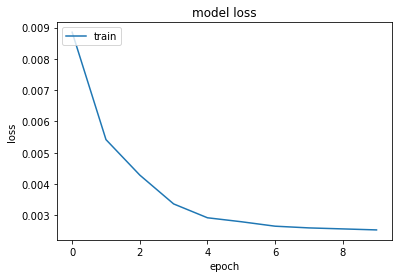

[[0.79744691 0.01408451 0.991     ]
 [0.59205073 0.03448276 0.72      ]
 [0.55702937 0.11111111 0.68      ]
 [0.5270167  0.04       0.59      ]
 [0.4786323  0.03846154 0.44      ]
 [0.45188734 0.04545455 0.43341564]
 [0.38297749 0.09090909 0.41      ]
 [0.41279837 0.05       0.4       ]
 [0.39703849 0.04166667 0.39      ]
 [0.39672169 0.5        0.39      ]
 [0.54863393 0.01694915 0.54      ]
 [0.40542799 0.03030303 0.38      ]
 [0.4817467  0.16666667 0.51      ]
 [0.58172858 0.02857143 0.55      ]
 [0.41249114 0.03703704 0.41      ]
 [0.54915988 0.1        0.508     ]
 [0.37271646 0.33333333 0.38      ]
 [0.43959472 0.02083333 0.48      ]
 [0.5483703  0.02325581 0.54      ]
 [0.52695447 0.05882353 0.56      ]
 [0.50578606 0.01785714 0.56      ]
 [0.59119183 0.06666667 0.57      ]
 [0.61326605 0.25       0.61      ]
 [0.61468726 0.01470588 0.61      ]
 [0.66511613 0.14285714 0.65      ]
 [0.5211128  0.02325581 0.58333333]
 [0.64425725 0.01515152 0.67      ]
 [0.64315003 0.08333333 0.63

In [7]:
## Previous loss: loss: 2.1564e-04 - val_loss: 0.0016
## 512, 1e-4, no dropout, no weights = loss: 8.8952e-04 - val_loss: 9.5390e-04
## 1024, 3e-5, no dropout, no weights = loss: 0.0015 - val_loss: 0.0020 (best performing!)
## 1024, 3e-5, no dropout, weights = loss: 2.4845e-04 - val_loss: 0.0025
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train_values = x_train[:100]
print(np.c_[model.predict(train_values), train_trader_weights[:100], y_train[:100]])
test_values = x_val[:100]
print(np.c_[model.predict(test_values), val_trader_weights[:100], y_val[:100]])

In [8]:
model.save('DeepTraderv3.h5')

In [14]:
new_model = tf.keras.models.load_model('DeepTraderv3_no_weights.h5')

new_model.evaluate(x_val,  y_val, verbose=1) 

1084158/1084158 [==============================] - 151s 139us/sample - loss: 0.0020


0.0019653245837587055

In [16]:
## Shuffle each column systematically to see the effect on loss
for i in range(0, x_val.shape[1]):
    modx_val = np.copy(x_val)

    # Shuffle first column of modified x_val
    np.random.shuffle(modx_val[:,i])
    print(modx_val[0,i])
    #np.random.shuffle(modx_val[:,i])
    print(modx_val[0,i])
    new_model.evaluate(modx_val,  y_val, verbose=1) 

#### Ideal loss: 6.5164e-04 --- WEIGHTED TRADERS

## time = loss: 7.4031e-04, 7.3929e-04
## ask/bid flag = loss: 0.0032
## customer order = loss: 0.0043
## spread - loss: 0.0024
## midprice - loss: 0.0086
## microprice - loss: 0.0018
## best bid - loss: 0.0054
## best ask - loss: 7.3251e-04, 7.3453e-04
## time since last trade - loss: 6.5241e-04, 6.5216e-04
## LOB imbalance - 6.9200e-04, 6.9134e-04
## total quotes - 6.5322e-04, 6.5318e-04
## p* - loss: 6.5659e-04, 6.5649e-04
## Smith's alpha - loss: 6.5867e-04, 6.5885e-04

#### Ideal loss: 0.0020 --- UNWEIGHTED TRADERS (all same)

## time = loss: 0.0020, 0.0020
## ask/bid flag = loss: 0.0036, 0.0036
## customer order = loss: 0.0070, 0.0070
## spread - loss: 0.0025, 0.0025
## midprice - loss: 0.0034, 
## microprice - loss: 0.0025
## best bid - loss: 0.0075
## best ask - loss: 0.0020
## time since last trade - loss: 0.0020
## LOB imbalance - 0.0020
## total quotes - 0.0020
## p* - loss: 0.0020
## Smith's alpha - loss: 0.0020


[0.12594831]
[0.12594831]
1084158/1084158 [==============================] - 146s 135us/sample - loss: 0.0020
[1.]
[1.]
1084158/1084158 [==============================] - 145s 134us/sample - loss: 0.0036
[0.15]
[0.15]
1084158/1084158 [==============================] - 144s 133us/sample - loss: 0.0070
[0.14363636]
[0.14363636]
1084158/1084158 [==============================] - 143s 132us/sample - loss: 0.0025
[0.16]
[0.16]
1084158/1084158 [==============================] - 149s 137us/sample - loss: 0.0034
[0.12207792]
[0.12207792]
1084158/1084158 [==============================] - 132s 121us/sample - loss: 0.0025
[0.50666667]
[0.50666667]
1084158/1084158 [==============================] - 125s 115us/sample - loss: 0.0075
[0.11]
[0.11]
1084158/1084158 [==============================] - 153s 141us/sample - loss: 0.0020
[0.12604341]
[0.12604341]
1084158/1084158 [==============================] - 150s 139us/sample - loss: 0.0020
[0.]
[0.]
1084158/1084158 [==============================] - 1

In [31]:
data.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07,1.084158e+07
mean,3.132783e+02,4.998728e-01,1.005552e+02,8.221978e+00,1.017929e+02,1.017555e+02,9.785417e+01,1.060761e+02,1.487492e+00,-4.642593e-01,2.973506e+01,1.014007e+02,1.087417e-01,1.016784e+02
std,1.748708e+02,5.000000e-01,2.222623e+01,1.791955e+01,1.301607e+01,1.322090e+01,1.132019e+01,1.926697e+01,1.373372e+00,4.994087e-01,8.904971e+00,9.897357e+00,4.088805e-02,1.079134e+01
min,2.500000e-01,0.000000e+00,5.000000e+01,-1.500000e+02,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.250000e-02,-1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01
25%,1.609125e+02,0.000000e+00,8.731626e+01,1.000000e+00,9.500000e+01,9.500000e+01,9.100000e+01,9.800000e+01,5.000000e-01,-1.000000e+00,2.300000e+01,9.596383e+01,8.284752e-02,9.400000e+01
50%,3.172125e+02,0.000000e+00,1.010000e+02,3.592593e+00,1.012992e+02,1.012843e+02,9.800000e+01,1.050000e+02,1.100000e+00,0.000000e+00,3.000000e+01,1.015867e+02,9.943374e-02,1.014566e+02
75%,4.735500e+02,1.000000e+00,1.140000e+02,1.166667e+01,1.080000e+02,1.080000e+02,1.050000e+02,1.130000e+02,2.050000e+00,0.000000e+00,3.600000e+01,1.072586e+02,1.256213e-01,1.090000e+02
max,6.000000e+02,1.000000e+00,1.500000e+02,9.500000e+02,5.750000e+02,7.700000e+02,1.500000e+02,1.000000e+03,2.996250e+01,1.000000e+00,6.500000e+01,1.500000e+02,8.724786e-01,1.500000e+02
